
# ================================
# 📦 IMPORT DES LIBRAIRIES
# ================================


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Style des graphiques

In [61]:
sns.set_theme(style="whitegrid")
plt.style.use("ggplot")


# ================================
# 📁 CHARGEMENT DES DONNÉES
# ================================

In [62]:
# Remplacer le chemin par l’endroit où se trouvent tes fichiers si besoin
customers = pd.read_csv("customers.csv", sep=";", low_memory=False)
products = pd.read_csv("products.csv", sep=";", low_memory=False)
transactions = pd.read_csv("Transactions.csv", sep=";", low_memory=False)

# Conversion explicite de birth en année (entier)
customers["birth"] = pd.to_numeric(customers["birth"], errors="coerce")
customers = customers.dropna(subset=["birth"])  # enlève les lignes où birth est vide
customers["birth"] = customers["birth"].astype(int)

# Calcul de l’âge
current_year = datetime.now().year
customers["age"] = current_year - customers["birth"]

# Contrôle rapide pour vérifier
print(customers[["birth", "age"]].sample(10))

      birth  age
2996   1953   72
3464   1957   68
874    1977   48
7303   1974   51
4392   1968   57
6533   1974   51
4984   1982   43
380    1968   57
6973   1997   28
679    1957   68



# ================================
# 🧼 NETTOYAGE DES DONNÉES
# ================================

In [63]:

# Renommer les colonnes
customers.columns = ["client_id", "sex", "birth", "age"]
products.columns = ["id_prod", "price", "categ"]
transactions.columns = ["id_prod", "date", "session_id", "client_id"]

# Convertir les types
products["price"] = products["price"].astype(float)
transactions["date"] = pd.to_datetime(transactions["date"])

# ================================
# 🔗 FUSION DES TABLES
# ================================

In [64]:
df = transactions.merge(products, on="id_prod", how="left")
df = df.merge(customers, on="client_id", how="left")

# ================================
# 🗓️ ANALYSE TEMPORELLE
# ================================

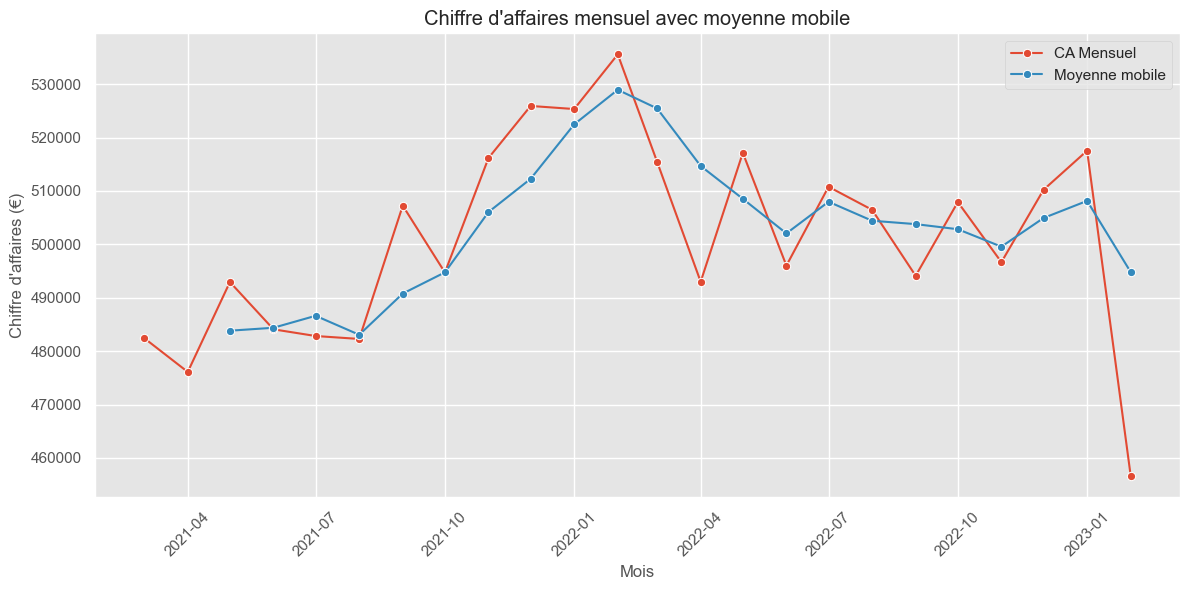

In [65]:

# Créer une colonne "mois"
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

# 1. Chiffre d'affaires mensuel
monthly_sales = df.groupby("month")["price"].sum().reset_index()

# 1b. Moyenne mobile sur 3 mois
monthly_sales["rolling_avg"] = monthly_sales["price"].rolling(window=3).mean()

# Tracé du chiffre d’affaires avec moyenne mobile
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="month", y="price", label="CA Mensuel", marker="o")
sns.lineplot(data=monthly_sales, x="month", y="rolling_avg", label="Moyenne mobile", marker="o")
plt.title("Chiffre d'affaires mensuel avec moyenne mobile")
plt.xlabel("Mois")
plt.ylabel("Chiffre d'affaires (€)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# ================================
# 🏷️ ANALYSE PAR CATÉGORIE
# ================================

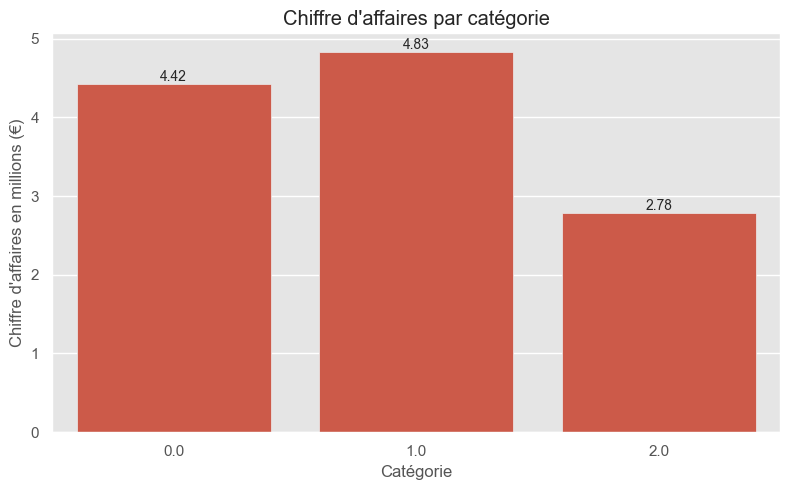

In [66]:

# 2. CA par catégorie
sales_by_category = df.groupby("categ")["price"].sum().reset_index()

# Conversion en millions si nécessaire
sales_by_category["price_millions"] = sales_by_category["price"] / 1e6

# Tracé
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=sales_by_category, x="categ", y="price_millions")

# Ajout des valeurs sur les barres
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom')

# Titres et labels
plt.title("Chiffre d'affaires par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Chiffre d'affaires en millions (€)")
plt.tight_layout()
plt.show()


# ================================
# 👥 CLIENTS ET TRANSACTIONS
# ================================

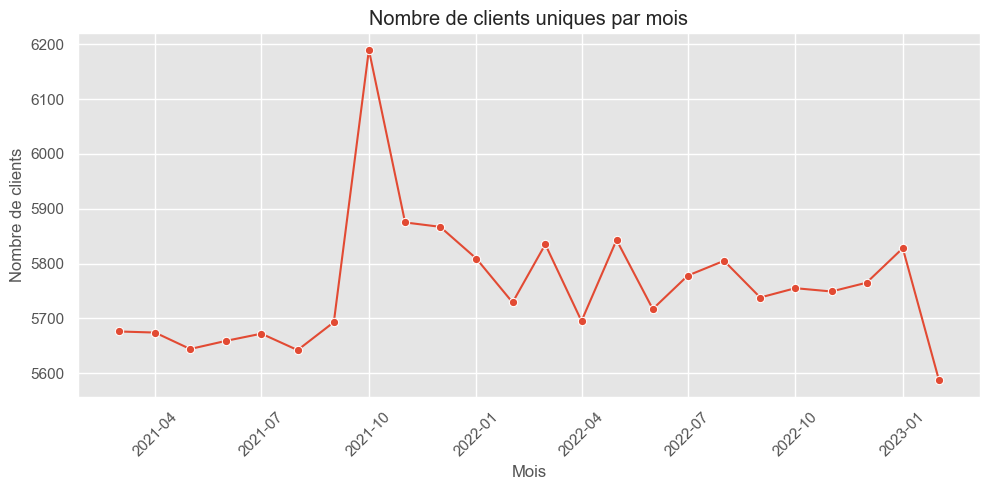

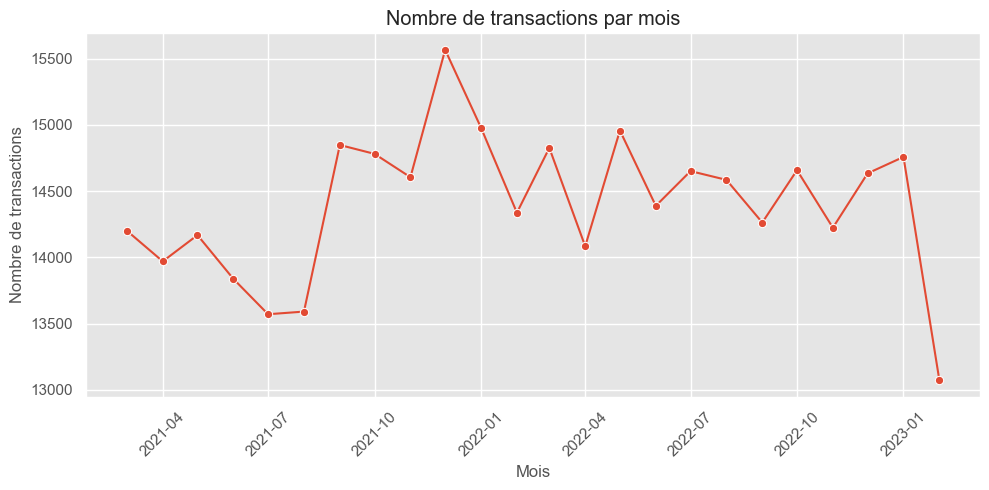

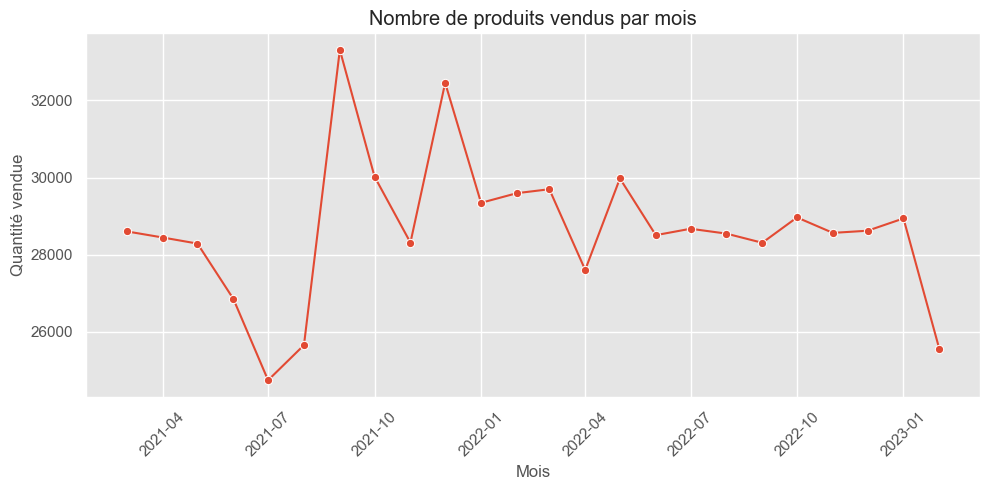

In [67]:
# 3. Nombre de clients uniques par mois
clients_per_month = df.groupby("month")["client_id"].nunique().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=clients_per_month, x="month", y="client_id", marker="o")
plt.title("Nombre de clients uniques par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de clients")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Nombre de transactions par mois
transactions_per_month = df.groupby("month")["session_id"].nunique().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=transactions_per_month, x="month", y="session_id", marker="o")
plt.title("Nombre de transactions par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Nombre de produits vendus par mois
products_per_month = df.groupby("month")["id_prod"].count().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=products_per_month, x="month", y="id_prod", marker="o")
plt.title("Nombre de produits vendus par mois")
plt.xlabel("Mois")
plt.ylabel("Quantité vendue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# ================================
# 🏆 TOP / FLOP PRODUITS
# ================================

In [68]:
# 6. Top 10 produits les plus vendus
top_products = df["id_prod"].value_counts().head(10).reset_index()
top_products.columns = ["ID produit", "Quantité vendue"]
print("Top 10 des produits les plus vendus :")
display(top_products)

# 7. Flop 10 produits les moins vendus (filtrés à ≤ 5 ventes)
product_counts = df["id_prod"].value_counts()
flop_products = product_counts[product_counts <= 5].tail(10).reset_index()
flop_products.columns = ["ID produit", "Quantité vendue"]
print("Flop 10 des produits les moins vendus (≤ 5 ventes) :")
display(flop_products)

Top 10 des produits les plus vendus :


,ID produit,Quantité vendue
0,1_369,2340
1,1_417,2269
2,1_414,2246
3,1_498,2202
4,1_425,2163
5,1_403,2040
6,1_413,2036
7,1_412,2014
8,1_406,2003
9,1_407,2001


Flop 10 des produits les moins vendus (≤ 5 ventes) :


,ID produit,Quantité vendue
0,0_1284,1
1,0_1498,1
2,2_81,1
3,0_549,1
4,0_1151,1
5,2_23,1
6,0_833,1
7,0_2201,1
8,0_1379,1
9,0_1633,1



# ================================
# 🧁 RÉPARTITION PAR CATÉGORIE
# ================================

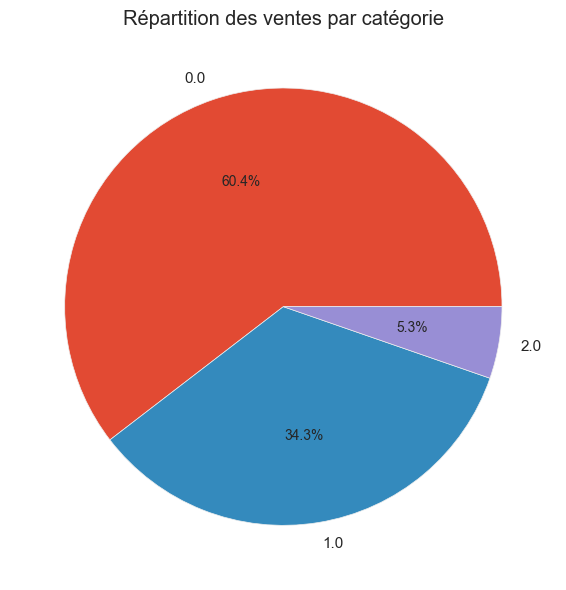

In [69]:
# 8. Proportions des ventes par catégorie
sales_distribution = df["categ"].value_counts(normalize=True).reset_index()
sales_distribution.columns = ["categ", "proportion"]

plt.figure(figsize=(6, 6))
plt.pie(sales_distribution["proportion"], labels=sales_distribution["categ"], autopct='%1.1f%%')
plt.title("Répartition des ventes par catégorie")
plt.tight_layout()
plt.show()

# === 📊 COURBE DE LORENZ + INDICE DE GINI ===

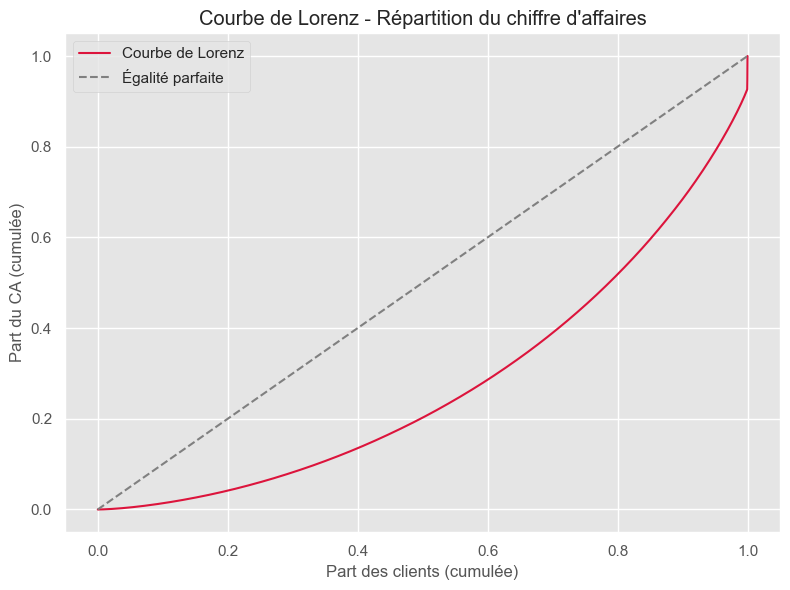

'Indice de Gini : 0.4419'

In [70]:

client_revenue = df.groupby("client_id")["price"].sum().sort_values().reset_index()
client_revenue["cum_revenue"] = client_revenue["price"].cumsum() / client_revenue["price"].sum()
client_revenue["cum_clients"] = np.arange(1, len(client_revenue)+1) / len(client_revenue)

# Tracé de la courbe de Lorenz
plt.figure(figsize=(8, 6))
plt.plot(client_revenue["cum_clients"], client_revenue["cum_revenue"], label="Courbe de Lorenz", color="crimson")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Égalité parfaite")
plt.title("Courbe de Lorenz - Répartition du chiffre d'affaires")
plt.xlabel("Part des clients (cumulée)")
plt.ylabel("Part du CA (cumulée)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcul de l'indice de Gini
lorenz_y = client_revenue["cum_revenue"].values
lorenz_x = client_revenue["cum_clients"].values
lorenz_y = np.insert(lorenz_y, 0, 0)
lorenz_x = np.insert(lorenz_x, 0, 0)
gini_index = 1 - 2 * np.trapezoid(lorenz_y, lorenz_x)

display(f"Indice de Gini : {round(gini_index, 4)}")


# ================================
# === 🔍 CORRÉLATIONS DEMANDÉES PAR JULIE ===
# ================================

In [71]:

# Supprime les lignes où une des variables nécessaires est manquante
df_corr = df[df[["age", "price", "session_id", "categ", "sex", "client_id"]].notna().all(axis=1)]
df_corr = df_corr[(df_corr["age"] >= 12) & (df_corr["age"] <= 100)]  # Optionnel : filtre sur âges plausibles

# 1. Genre vs Catégorie des livres (table croisée)
genre_categ = pd.crosstab(df_corr["sex"], df_corr["categ"], normalize='index') * 100
print("\nRépartition des catégories par genre (%):")
display(genre_categ.round(1))

# 2. Âge vs montant total des achats
age_spending = df_corr.groupby("client_id").agg({"age": "first", "price": "sum"}).dropna()
corr1 = age_spending["age"].corr(age_spending["price"])

# 3. Âge vs fréquence d’achat (nombre de sessions)
freq_achats = df_corr.groupby("client_id").agg({"age": "first", "session_id": pd.Series.nunique}).dropna()
corr2 = freq_achats["age"].corr(freq_achats["session_id"])

# 4. Âge vs panier moyen
panier_moyen = df_corr.groupby("client_id").agg({
    "age": "first",
    "price": "sum",
    "session_id": pd.Series.nunique
}).dropna()
panier_moyen["panier_moyen"] = panier_moyen["price"] / panier_moyen["session_id"]
corr3 = panier_moyen["age"].corr(panier_moyen["panier_moyen"])

# 5. Âge vs catégorie des livres achetés
clients_valides = df_corr[["client_id", "age"]].dropna().drop_duplicates()

age_cat = (
    df_corr[df_corr["client_id"].isin(clients_valides["client_id"])]
    .groupby(["client_id", "categ"])
    .size()
    .unstack()
    .fillna(0)
)
age_cat["age"] = clients_valides.set_index("client_id")["age"]

stds = age_cat.std()
valid_cols = stds[(stds != 0) | (stds.index == "age")].index

excluded = set(age_cat.columns) - set(valid_cols)
if excluded:
    print("Colonnes exclues (variance nulle, sauf 'age') :", list(excluded))

age_cat_valid = age_cat[valid_cols].dropna()
corrs_cat = age_cat_valid.corrwith(age_cat_valid["age"]).drop("age")

print("\nCorrélations demandées par Julie :")
print(f"- Âge vs montant total des achats : {corr1:.3f}")
print(f"- Âge vs fréquence d’achat        : {corr2:.3f}")
print(f"- Âge vs panier moyen             : {corr3:.3f}")

print("\nCorrélations Âge vs Catégorie des livres achetés :")
display(corrs_cat.round(3))
#Catégoriel vs Catégoriel
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))



# Petit contrôle final
print(df_corr[["age", "birth"]].describe())
print("Ages uniques (échantillon):", df_corr["age"].unique()[:10])
cramersv_score = cramers_v(df_corr["sex"], df_corr["categ"])
print(f"\nForce d'association catégorielle (Cramer's V) entre genre et catégorie : {cramersv_score:.3f}")


Répartition des catégories par genre (%):


categ,0.0,1.0,2.0
sex,,,
f,60.1,34.8,5.0
m,60.7,33.7,5.6



Corrélations demandées par Julie :
- Âge vs montant total des achats : -0.040
- Âge vs fréquence d’achat        : 0.034
- Âge vs panier moyen             : -0.617

Corrélations Âge vs Catégorie des livres achetés :


categ
0.0    0.002
1.0    0.070
2.0   -0.122
dtype: float64

                 age          birth
count  687534.000000  687534.000000
mean       47.182609    1977.817391
std        13.607935      13.607935
min        21.000000    1929.000000
25%        38.000000    1970.000000
50%        45.000000    1980.000000
75%        55.000000    1987.000000
max        96.000000    2004.000000
Ages uniques (échantillon): [58. 65. 37. 36. 69. 44. 45. 57. 42. 55.]

Force d'association catégorielle (Cramer's V) entre genre et catégorie : 0.015


## 📝 Conclusion de l’analyse des corrélations

Notre analyse montre que **l’âge des clients influence peu la plupart des comportements d’achat** :

- **Montant total des achats et fréquence d’achat**
  Les corrélations obtenues sont proches de zéro, ce qui indique que le volume d’achats et la régularité des achats ne varient pas significativement selon l’âge des clients.

- **Panier moyen**
  Une **corrélation négative notable** (−0,62) est observée : les clients plus jeunes réalisent des achats de montant moyen plus élevé, tandis que les clients plus âgés effectuent des achats moins élevés à chaque transaction.

- **Catégories de livres achetés**
  L’âge n’est globalement pas déterminant dans le choix des catégories, même si la catégorie 2 est légèrement moins populaire chez les clients plus âgés et la catégorie 1 un peu plus présente.

**En résumé**
L’âge des clients n’a que peu d’impact sur la fréquence ou le volume global des achats, mais il est associé à un panier moyen plus faible chez les profils les plus âgés. Les préférences de catégories restent très proches d’un groupe d’âge à l’autre.
Ces résultats peuvent aider à affiner la stratégie commerciale, notamment en adaptant les offres ou recommandations selon la tranche d’âge ciblée.

---
